In [5]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A
import json

In [73]:
def get_points(image_dict):
    points = []
    labels = []

    for i in range(len(image_dict['regions'])):
        for j in range(len(image_dict['regions'][i]['shape_attributes']['all_points_x'])):
            curr = (image_dict['regions'][i]['shape_attributes']['all_points_x'][j],
                    image_dict['regions'][i]['shape_attributes']['all_points_y'][j])
            points.append(curr)
            labels.append(str(i))

    return points, labels

In [14]:
def get_lists(keypoints):
    all_points_x = []
    all_points_y = []

    for x, y in keypoints:
        all_points_x.append(x)
        all_points_y.append(y)
    return all_points_x, all_points_y

In [127]:
def visualize(image, points):
    im_cp = image.copy()
    for point in points:
        cv2.circle(im_cp, (point[0],point[1]), radius=7, color=(255, 0, 0), thickness=-1)
    plt.figure(figsize=(8, 10))
    plt.axis('off')
    plt.imshow(im_cp)

In [15]:
def fix_keypoints(keypoints_):
    keypoints = []
    for point in keypoints_:
        keypoints.append((int(point[0]), int(point[1])))
    return keypoints

In [81]:
transform = A.Compose([
    A.RandomCrop(width=500 , height=500),
    A.RandomBrightnessContrast(p=0.8)
], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))


In [58]:
two_dym_types = [ 'aztec_code',
        'data_matrix',
        'maxi_code',
        'pdf_417',
        'qr',
        'databar_expanded_stacked',
        'generic2d',
        'generic_mixed',
        'databar_stacked',
        'databar_expanded']

In [104]:
def get_regions(initial_regions, keypoints, labels):
    regions = []
    curr_x, curr_y = [], []
    for i in range(len(labels)):
        curr_x.append(keypoints[i][0])
        curr_y.append(keypoints[i][1])
        if i + 1 == len(labels) or labels[i + 1] != labels[i]:
            curr_dict = dict(initial_regions[int(labels[i])])
            old_len = len(curr_dict['shape_attributes']['all_points_x'])
            curr_dict['shape_attributes']['all_points_x'] = curr_x
            curr_dict['shape_attributes']['all_points_y'] = curr_y
            if len(curr_x) < old_len:
                curr_dict['region_attributes']['code integrity'] = 'invalid'
            regions.append(curr_dict)
            curr_x, curr_y = [], []

    return regions

In [107]:
def augment(image_name, full_data, transform):
    image_path = 'images/' + image_name
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    for full_name, file_data_ in full_data['_via_img_metadata'].items():
        file_data = dict(file_data_)
        if image_name in full_name:
            keypoints, labels = get_points(file_data)
            
            transformed = transform(image=image, keypoints=keypoints, class_labels=labels)
            transformed_image = transformed['image']
            transformed_keypoints = fix_keypoints(transformed['keypoints'])
            transformed_labels = transformed['class_labels']

            print(transformed_labels)

            file_data['regions'] = get_regions(file_data['regions'], transformed_keypoints, transformed_labels)

            transformed_image_name = image_name.split('.')[0] + '_' + str(random.randint(1, 10 ** 5)) + '.jpg'
            file_data['filename'] = transformed_image_name

            plt.imsave('augmented_images/' + transformed_image_name, transformed_image)
            return file_data

In [117]:
with open('via_project_9Nov2024_20h28m.json', 'r') as f:
    data = json.load(f)

d = augment('photo_2024-10-29_02-35-07.jpg', data, transform)


['0', '0', '1', '1', '1']


In [118]:
d

{'filename': 'photo_2024-10-29_02-35-07_94192.jpg',
 'size': 133103,
 'regions': [{'shape_attributes': {'name': 'polygon',
    'all_points_x': [395, 475],
    'all_points_y': [50, 4]},
   'region_attributes': {'type': 'ean_13', 'code integrity': 'invalid'}},
  {'shape_attributes': {'name': 'polygon',
    'all_points_x': [315, 109, 204],
    'all_points_y': [248, 1, 285]},
   'region_attributes': {'type': 'ean_13', 'code integrity': 'invalid'}}],
 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}

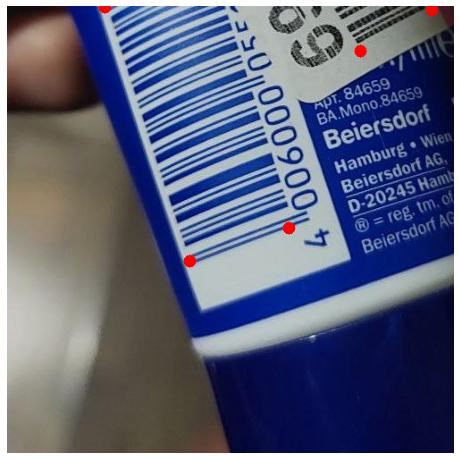

In [128]:
img = cv2.imread('augmented_images/' + d['filename'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualize(img, get_points(d)[0])